<a href="https://colab.research.google.com/github/umarmohammed/measuring-bias-in-a-dataset/blob/project-4/4.%20Recompute%20bias%20metrics%20on%20transformed%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load the dataset and predictions

In [1]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load the dataset with predictions
from joblib import load

data = load("/content/drive/MyDrive/liveProject/mortgate_data_with_predictions.pkl.gz")

df = data[0]
ypred_label = data[1]

## 2. Compute and chart bias metrics

In [3]:
# Install AIF360
!pip install aif360

     |████████████████████████████████| 174kB 8.6MB/s 


In [4]:
# Create a BinaryLabelDataset to represent the data
from aif360.datasets import BinaryLabelDataset

dataset = BinaryLabelDataset(favorable_label=False, unfavorable_label=True, df=df, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

In [5]:
# Create a BinaryLabelDataset to represent the predictions
dataset_pred = dataset.copy() 
dataset_pred.labels = ypred_label

In [7]:
# Create a ClassificationMetric
from aif360.metrics import ClassificationMetric

privileged_group = [{'applicant_sex_name_Female': 0}] 
unprivileged_group = [{'applicant_sex_name_Female': 1}]
metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)

In [8]:
# Compute bias metrics 
import pandas as pd 

def compute_fair_metrics(metric):
  fair_metrics = {
    "DispImpact": [metric.disparate_impact, 0.8, 1.2], 
    "StatParity": [metric.statistical_parity_difference, -0.1, 0.1],
    "AvgOddsDiff": [metric.average_odds_difference, -0.1, 0.1],
    "EqualOppDiff": [metric.equal_opportunity_difference, -0.1, 0.1]
    }

  metrics = [[ff, fair_metrics[ff][0](), fair_metrics[ff][1], fair_metrics[ff][2]] for ff in fair_metrics]

  return pd.DataFrame(metrics, columns=["Metric", "Value", "Min", "Max"])

df_fair = compute_fair_metrics(metric)

df_fair

,Metric,Value,Min,Max
0,DispImpact,1.287024,0.8,1.2
1,StatParity,0.113421,-0.1,0.1
2,AvgOddsDiff,0.105941,-0.1,0.1
3,EqualOppDiff,0.107389,-0.1,0.1


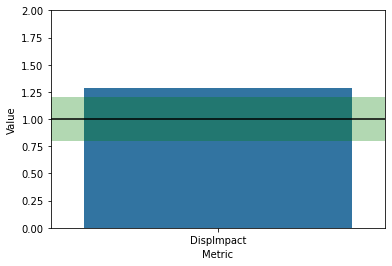

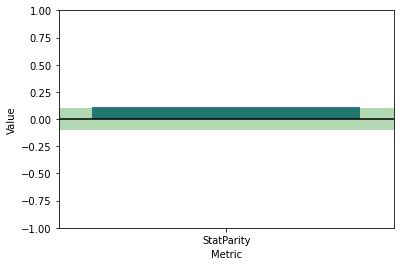

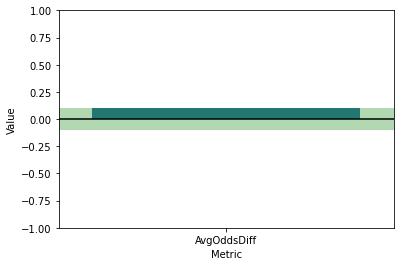

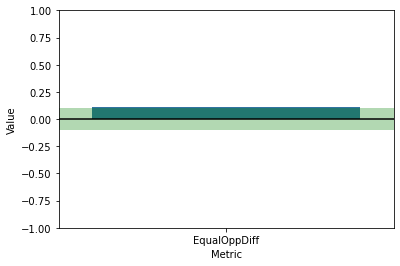

In [10]:
# Chart the metrics

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import numpy as np

def plot_metrics(df_fair): 
  def plot_metric(metric, ylim):
    fig, ax = plt.subplots()
    ax = sns.barplot(data=metric, x="Metric", y="Value")
    plt.axhline(np.mean(metric[["Min", "Max"]].values), color='black')
    plt.ylim(*ylim)
    range_height = metric[["Max"]].values[0][0] - metric[["Min"]].values[0][0]
    ax.add_patch(patches.Rectangle((-1, metric[["Min"]].values[0][0]), 2 , range_height, facecolor="green", alpha=0.3))

  plot_metric(df_fair.iloc[[0]], (0, 2))
  plot_metric(df_fair.iloc[[1]], (-1, 1))
  plot_metric(df_fair.iloc[[2]], (-1, 1))
  plot_metric(df_fair.iloc[[3]], (-1, 1))

plot_metrics(df_fair)

## 3. Post-process the model using Calibrated Equalised Odds

In [20]:
# Use the Calibrated Equalised Odds technique

from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

cep = CalibratedEqOddsPostprocessing(unprivileged_group, privileged_group)

dataset_pred_transformed = cep.predict(dataset_pred)

## 4. Recompute bias metrics

In [24]:
# Create a ClassificationMetric

metric_transformed = ClassificationMetric(dataset, dataset_pred_transformed, unprivileged_group, privileged_group)

In [25]:
# Compute bias metrics

df_fair = compute_fair_metrics(metric_transformed)
df_fair

,Metric,Value,Min,Max
0,DispImpact,1.138932,0.8,1.2
1,StatParity,0.066741,-0.1,0.1
2,AvgOddsDiff,0.000000,-0.1,0.1
3,EqualOppDiff,0.000000,-0.1,0.1


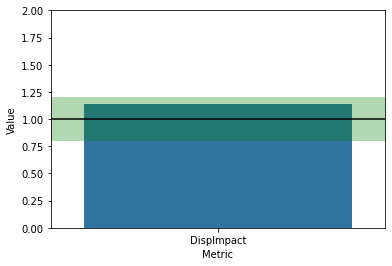

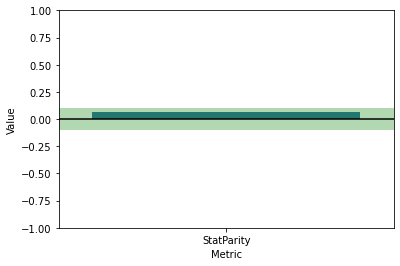

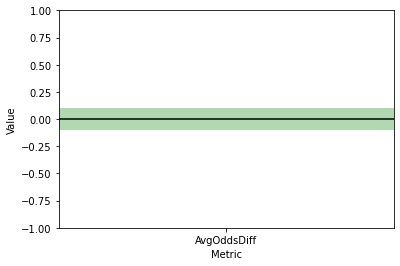

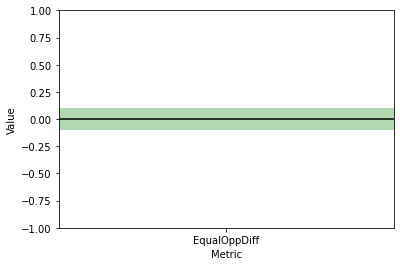

In [26]:
# Chart the metrics

plot_metrics(df_fair)

In [ ]:
# Show how to use the cep in a pipeline